In [13]:
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import OptimizeResult

from core import approx
from core.gradient_descent import steepest_descent
from core.high_order_optimization import newton_optimize, LBFGSNewtonDirectionApproximator, gauss_newton, dogleg, \
    BFGSNewtonDirectionApproximator
from core.utils import mesuare_time, plot_approx
%load_ext autoreload
%autoreload 2

from core.optimizer_evaluator import *
from core.abstract_analzyer import *
import scipy
import torch.optim
import math
from numpy.polynomial import Polynomial


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Сравнение `scipy.optimize.minimize` и `scipy.optimize.least_squares` с нашими методами

In [4]:
def loop(_):
    while True:
        pass
infinite = Algorithm("infinite", loop)
def err(_):
    raise Exception
error = Algorithm("error", err)
constantly = Algorithm("constantly", lambda _: "Hello")

compare_optimization_algorithms_in_table([infinite, error, constantly], [Problem("1", lambda x: x, [], lambda x: 1, None), Problem("2", lambda x: x, [], lambda x: 1, None)], 1)

=========== Testing infinite ===========
Got result TL at problem=1
Got result TL at problem=2
=========== Testing error ===========
Exception occurred: 
Got result × at problem=1
Exception occurred: 
Got result × at problem=2
=========== Testing constantly ===========
Got result Hello at problem=1
Got result Hello at problem=2
+-----------+------------+---------+--------------+
|   problem | infinite   | error   | constantly   |
+===========+============+=========+==============+
|         1 | TL         | ×       | Hello        |
+-----------+------------+---------+--------------+
|         2 | TL         | ×       | Hello        |
+-----------+------------+---------+--------------+


In [5]:
from scipy.optimize import HessianUpdateStrategy




In [4]:
def steps(iters):
    return lambda f, ps: len(ps) > iters

x = torch.linspace(-math.pi, math.pi, 200)
y = torch.sin(x)

nx = x.numpy()
ny = y.numpy()
noise = np.random.normal(0, 0.1, (ny.size,))
ny += noise

handmade result = [-2.38727670e-02  1.04713404e+00  3.37320327e-02 -1.93918465e-01
 -7.70301177e-03  1.25050762e-02  4.76602663e-04 -3.57494465e-04], time = 0.3580813407897949s


[]

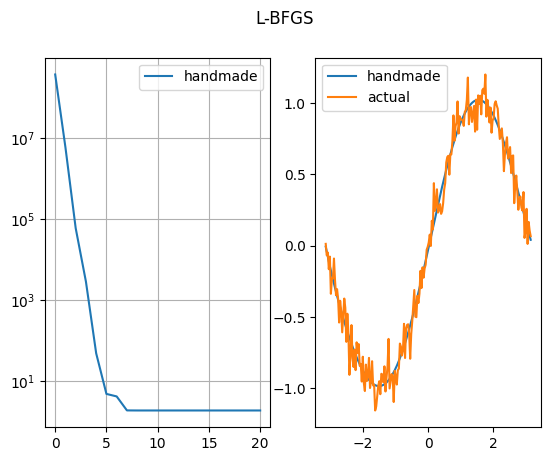

In [101]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx(
                            nx, ny, 8,
                            lambda r, dr, f, df, x0: newton_optimize(f, df, LBFGSNewtonDirectionApproximator(10), x0, fibonacci_search(200), steps(20))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('L-BFGS')
plt.plot()

handmade result = [-34.7859599   -9.19827129  13.30642728   6.19775419  -0.70072136
  -0.62575132], time = 0.3211040496826172s


[]

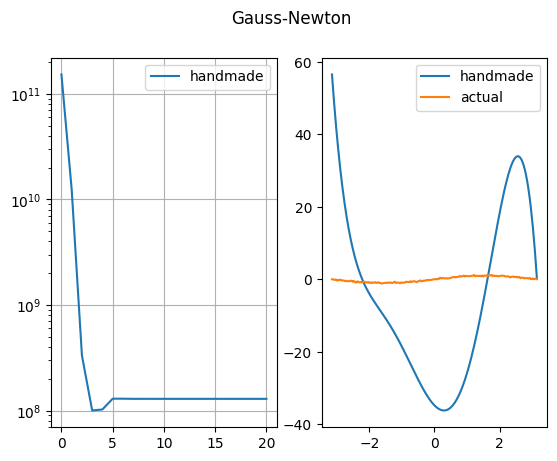

In [108]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx_residuals(
                            nx, ny, 6,
                            lambda r, dr, f, df, x0: gauss_newton(r, dr, x0, steps(20))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('Gauss-Newton')
plt.plot()

handmade result = [ 5.44924619  1.89350921  0.56477322 -0.93113627  0.1223704 ], time = 2.5924129486083984s


[]

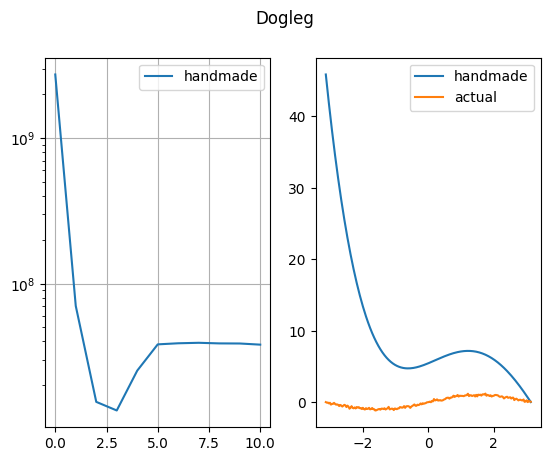

In [107]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx_residuals(
                            nx, ny, 5,
                            lambda r, dr, f, df, x0: dogleg(r, dr, 1, wolfe_conditions_search(0.1, 0.9), x0, steps(10))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('Dogleg')
plt.plot()

handmade result = [-2.13930933e-02  1.04713404e+00  2.47723371e-02 -1.93918465e-01
 -2.75719880e-03  1.25050762e-02 -3.83770827e-04 -3.57494465e-04
  4.62565216e-05], time = 0.405322790145874s


[]

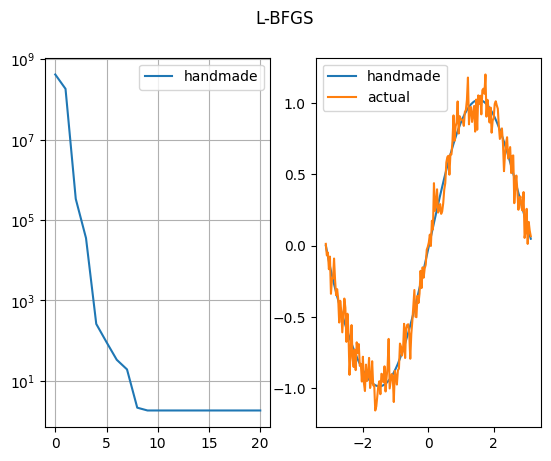

In [115]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx(
                            nx, ny, 9,
                            lambda r, dr, f, df, x0: newton_optimize(f, df, LBFGSNewtonDirectionApproximator(10), x0, fibonacci_search(200), steps(20))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('L-BFGS')
plt.plot()

# Таблица Сравнения


$${\displaystyle f({\boldsymbol {x}})=\sum _{i=1}^{n-1}\left[100\left(x_{i+1}-x_{i}^{2}\right)^{2}+\left(1-x_{i}\right)^{2}\right]}$$

$${\displaystyle q({\boldsymbol {x}})= x^T Q x$$



In [67]:
opt_algorithms = [
    Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=3]", lambda: LBFGSNewtonDirectionApproximator(5), list_point_number_and_time_extractor),
    Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=10]", lambda: LBFGSNewtonDirectionApproximator(10), list_point_number_and_time_extractor),

    Algorithm.quasi_newton_optimize_with_strategy("BFGS", lambda: BFGSNewtonDirectionApproximator(), list_point_number_and_time_extractor),

    Algorithm.gradient_descent("Steepest", steepest_descent, list_point_number_and_time_extractor),

    Algorithm.scipy_optimize_with_solver("BFGS", scipy_point_number_and_time_extractor),
    Algorithm.scipy_optimize_with_solver("L-BFGS-B", scipy_point_number_and_time_extractor),
]

In [70]:
problems = [
    Problem.from_rosen(10),
    Problem.from_rosen(100),


    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(50, 10)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 10)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 50)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 500)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(300, 500)),
    # Problem.from_quadratic_form(generate_positive_definite_quadratic_form(1000, 500)),
]

In [71]:
compare_optimization_algorithms_in_table(opt_algorithms, problems, 10)

=========== Testing hm.L-BFGS[m=3] ===========
Got result 85/0.04 at problem=Rosen[n=10]
Got result 583/0.37 at problem=Rosen[n=100]
Got result 41/0.01 at problem=Quadratic[n=50, k=10]
Got result 24/0.02 at problem=Quadratic[n=100, k=10]
Got result 39/0.04 at problem=Quadratic[n=100, k=50]
Got result 70/0.08 at problem=Quadratic[n=100, k=500]
Got result 86/0.16 at problem=Quadratic[n=300, k=500]
=========== Testing hm.L-BFGS[m=10] ===========
Got result 110/0.05 at problem=Rosen[n=10]
Got result 798/0.6 at problem=Rosen[n=100]
Got result 40/0.02 at problem=Quadratic[n=50, k=10]
Got result 66/0.11 at problem=Quadratic[n=100, k=10]
Got result 43/0.04 at problem=Quadratic[n=100, k=50]
Got result 86/0.11 at problem=Quadratic[n=100, k=500]
Got result 100/0.14 at problem=Quadratic[n=300, k=500]
=========== Testing hm.BFGS ===========
Got result 56/0.02 at problem=Rosen[n=10]
Exception occurred: 
Got result × at problem=Rosen[n=100]
Got result 60/0.02 at problem=Quadratic[n=50, k=10]
Got resu

# Least Squares

In [144]:
ls_algorithms = [
    Algorithm.dogleg(list_point_number_and_time_extractor),
    Algorithm.gauss_newton(list_point_number_and_time_extractor),

    Algorithm.optimizer_as_ls_solver(Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=3]", lambda: LBFGSNewtonDirectionApproximator(5), list_point_number_and_time_extractor)),

    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "trf"),
    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "dogbox"),
]
ls_problems = [
    LeastSquaresProblem.quadratic_residuals(2, 2, 2),
    LeastSquaresProblem.quadratic_residuals(10, 10, 200),
    LeastSquaresProblem.quadratic_residuals(100, 100, 200)
]

In [145]:
compare_optimization_algorithms_in_table(ls_algorithms, ls_problems, 10)

=========== Testing hm.Dogleg ===========
Got result 15/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 18/0.02 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 18/1.47 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing hm.Gauss-Newton ===========
Got result 18/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 18/0.0 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 18/0.22 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing hm.L-BFGS[m=3] ===========
Got result 9/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 45/0.07 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 39/5.45 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing sp.LS[trf] ===========
Got result 11/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 15/0.0 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 16/0.31 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing

# Выводы сравнения эффективности и производительности

- По количеству итераций — результаты сопоставимы,
- Однако затраченное время различается: алгоритмы на C/Fortran обычно работают быстрее.
    - Особенно разница заметна на L-BFGS: `0.16s` vs `0.02s` при ≈ одинаковом количестве итераций.
    - А вот для BFGS — разница на больщих размерностях небольшая, так как там более высокая часть времени занята именно работой с матрицами, которая производится на Fortran-е (на нём написан numpy).


# Сравнение scipy с ограничениями и без них

In [38]:
ls_bounded_algorithms = [
    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "trf"),
    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "dogbox"),
]


ls_bounded_problems = [
    LeastSquaresProblem.quadratic_residuals(10, 10, 200, (-np.inf, np.inf)),
    LeastSquaresProblem.quadratic_residuals(10, 10, 200, (-1, 1)),
    LeastSquaresProblem.quadratic_residuals(10, 10, 200, (-0.001, 0.001)),

    LeastSquaresProblem.polynom_approx(nx, ny, 20, (-np.inf, np.inf)),
    LeastSquaresProblem.polynom_approx(nx, ny, 20, (-100, 100)),
    LeastSquaresProblem.polynom_approx(nx, ny, 20, (-1.5, 1.5)),

    LeastSquaresProblem.pattern_approximation("noised sine by poly", nx, noisify(np.sin(nx), 0.1), poly_pattern, poly_pattern_grad, random_normalized_vector(5), (-1, 1)),
    LeastSquaresProblem.pattern_approximation("noised exp by self", np.linspace(0, 5, 20), noisify(exp_pattern(exp_p0)(np.linspace(0, 5, 20)), 0.1),
                                               exp_pattern, exp_pattern_grad, exp_p0 + random_normalized_vector(4) * 0.3, (-5, 5)),
]

In [39]:
compare_optimization_algorithms_in_table(ls_bounded_algorithms, ls_bounded_problems, 10)

=========== Testing sp.LS[trf] ===========
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 2.001e-07  1.115e-07  1.533e-07  1.581e-07  1.765e-07
                7.146e-08  1.384e-07  6.343e-08  1.155e-07  1.230e-07]
           x: [ 2.239e-05  1.793e-05  1.113e-05  2.445e-05  1.035e-05
                4.897e-06  9.287e-07  2.365e-05  2.280e-06  5.739e-06]
        cost: 9.444599586241215e-14
         jac: [[ 5.195e-03  3.463e-03 ... -5.314e-04 -2.060e-04]
               [ 2.959e-03  2.640e-04 ... -7.826e-04 -1.693e-03]
               ...
               [ 4.180e-03  7.222e-04 ... -1.166e-03 -2.675e-03]
               [ 3.549e-03  2.523e-03 ...  4.826e-04  3.032e-03]]
        grad: [ 3.824e-09  3.367e-09  1.290e-09  4.913e-09  4.567e-11
               -8.372e-10 -3.290e-09  4.943e-09 -1.839e-09 -1.511e-09]
  optimality: 4.943107149705041e-09
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.00

Вывод: знание границ ускоряет работу методов